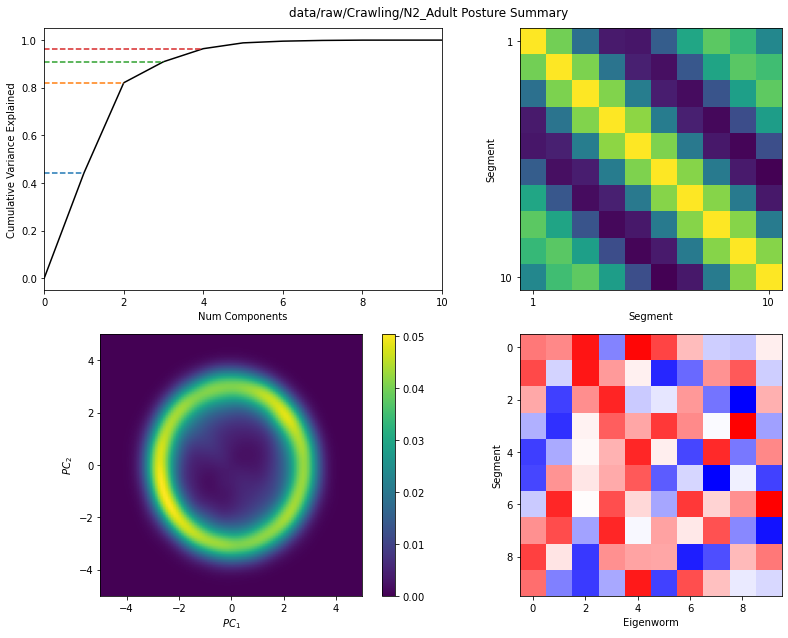

In [16]:
# Imports
from pathlib import Path

import numpy as np
np.random.default_rng(42)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

# define your directory here
datapath = Path('./data/raw/Crawling/N2_Adult')
angles=[]
files=[]
for count, file in enumerate(datapath.glob('*.txt')):
    try:
        # Data Pre-processing/cleaning step to remove header of multiple lines (at times)
        with open(file) as curr_file:
            lines = curr_file.readlines()
            lines = [line.rstrip() for line in lines]
        ind = 0
        for i in range(len(lines)):
            if lines[i][:4] == 'Time':
                ind = i
                break
        # Actually loading the data from .txt
        data = np.loadtxt(file, dtype='float', skiprows=ind+1)
        angles.append(data[:, 1:])  # slice out time column
        files.append(file)
    except UnicodeDecodeError:
            print(f'{file} has unknown character')
    except ValueError as e:
            print(f'{file} has missing rows')
            
if len(angles) == 0:
    raise ValueError(f'No data found in {datapath.as_posix()}')
#scale and perform pca on data
stds = []
for angle in angles:
  scaler = StandardScaler() #initialize a standarizing object
  stds.append(scaler.fit_transform(angle)) #normalize the data
stds = np.vstack(stds) #stack to (n_frames, n_segments) for all data

pca = PCA(n_components=10) #init pca object
pcs = pca.fit_transform(stds) #fit and transform the angles data

# alternatively, load presaved pca object
# file = open('pca.obj', 'rb')
# pca = pickle.load(file)
# pcs = pca.fit_transform(stds) #fit and transform the angles data
#calculate cumvar, eigenworms, and PC histogram
cumvar = np.cumsum(np.hstack(([0], pca.explained_variance_ratio_)))

kde = gaussian_kde(pcs[:,0:2].T)
xmin = -5 # np.min(pcs[:,0])
xmax = 5 # np.max(pcs[:,0])
ymin = -5 # np.min(pcs[:,1])
ymax = 5 # np.max(pcs[:,1])

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# segment covariance matrix
C = np.cov(stds.T) # data must be (n_segments, n_frames)

#plotting
fig = plt.figure(figsize=(12, 9))
gs = GridSpec(2,2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

#cumulative variance explained
ax = ax1
ax.plot(cumvar, 'k')
ax.hlines(y=cumvar[1:5],
          xmin=np.zeros(4),
          xmax=range(1,5),
          colors= plt.rcParams['axes.prop_cycle'].by_key()['color'][0:4],
          linestyles='dashed')
ax.set(xticks=np.arange(11, step=2),
    xticklabels=['0', '2', '4', '6', '8', '10'],
    xlabel="Num Components",
    xlim=[0, 10],
    ylabel="Cumulative Variance Explained")

# Covariance structure
ax = ax2
im2 = ax.imshow(C)
ax.set(xticks=[0,9], xticklabels=['1', '10'], xlabel='Segment',
        yticks=[0,9], yticklabels=['1', '10'], ylabel='Segment')
#2D PC distribution
ax=ax3
im1 = ax.imshow(Z, cmap='viridis',
        extent=[xmin, xmax, ymin, ymax])
ax.set(xlim = [-5, 5], ylim = [-5, 5], xlabel = r"$PC_1$", ylabel = r"$PC_2$")
plt.colorbar(im1, ax=ax)

#eigenworms
ax = ax4
im2 = ax.imshow(pca.components_.T, cmap='bwr')
ax.set(xlabel="Eigenworm", ylabel = "Segment")

fig.suptitle(f'{datapath.as_posix()} Posture Summary')
fig.tight_layout()